<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
!pip install tensorflow-gan tensorflow-addons -q

In [141]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Embedding
from tensorflow.keras.layers import Wrapper, AveragePooling2D, LeakyReLU, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from tqdm import tqdm 
import tensorflow_addons as tfa
# from tensorflow_addons.layers import SpectralNormalization //not working

from google.colab import drive, auth

print(tf.__version__)

2.8.2


In [142]:
drive.mount('/content/drive')
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.42.38.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.42.38.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [144]:
#@title CONSTS

IMAGE_SIZE = 32
BUFFER_SIZE = 13000
BATCH_SIZE = 32
EPOCHS = 200
LATENT_DIM = 120
CHECKPOINT_DIR = '/content/drive/MyDrive/BIGGAN_birds_32/checkpoints'
SAMPLES_DIR = '/content/drive/MyDrive/BIGGAN_birds_32/samples'
CHECKPOINT_INTERVAL = 50
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'


In [145]:
weight_initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=SEED
)
weight_regularizer = None
weight_regularizer_fully = None

In [146]:
def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
      dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [147]:
class SpectralNormalization(Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

            if not hasattr(self.layer, 'kernel'):
                raise ValueError(
                    '`SpectralNormalization` must wrap a layer that'
                    ' contains a `kernel` for weights')

            self.w = self.layer.kernel
            self.w_shape = self.w.shape.as_list()
            self.u = self.add_weight(
                shape=tuple([1, self.w_shape[-1]]),
                initializer=k.initializers.TruncatedNormal(stddev=0.02),
                name='sn_u',
                trainable=False,
                dtype=tf.float32)

        super(SpectralNormalization, self).build()

    @tf.function
    def call(self, inputs):
        """Call `Layer`"""
        # Recompute weights for each forward pass
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = tf.identity(self.u)
        
        _v = tf.matmul(_u, tf.transpose(w_reshaped))
        _v = _v / tf.maximum(tf.reduce_sum(_v**2)**0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u = _u / tf.maximum(tf.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u))

        self.layer.kernel = self.w / sigma

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

In [148]:
#@title ConditionalBatchNormalization

class ConditionalBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ConditionalBatchNormalization, self).__init__(**kwargs)
    
  def build(self, input_shape):
    batch, height, width, channels = input_shape
   
    self.linear_gamma = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_gamma'))
    self.linear_beta = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_beta'))
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, x, c, training=False):
    x = self.batchnorm(x, training=training)
    gamma = self.linear_gamma(c, training=training)  
    beta = self.linear_beta(c, training=training)

    return x * gamma[:, None, None] + beta[:, None, None]  

In [149]:
#@title SelfAttention

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        in_channels = int(input_shape[-1])

        self.conv_theta =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_phi =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_g =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//2, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_attn =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.sigma = self.add_weight('sigma', shape=[], initializer=tf.zeros_initializer())

    def call(self, x, training=None):
        batch_size, h, w, in_channels = map(int, x.shape.as_list())
        location_num = h*w
        downsampled_num = location_num//4

        theta = self.conv_theta(x, training=training)
        theta = tf.reshape(theta, [batch_size, location_num, in_channels//8])

        phi = self.conv_phi(x, training=training)
        phi = tf.nn.max_pool(phi, ksize=[2, 2], strides=2, padding='VALID')
        phi = tf.reshape(phi, [batch_size, downsampled_num, in_channels//8])

        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x, training=training)
        g = tf.nn.max_pool(g, ksize=[2, 2], strides=2, padding='VALID')
        g = tf.reshape(g, [batch_size, downsampled_num, in_channels//2])

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [batch_size, h, w, in_channels//2])
        attn_g = self.conv_attn(attn_g, training=training)

        return x + self.sigma * attn_g

In [150]:
#@title DBlock

class DBlock(Model):
  def __init__(self, channels, downsample=True, preactivation=True):
    super(DBlock, self).__init__()
    self.out_channels = channels
    self.hidden_channels = self.out_channels 
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.hidden_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.av_pool_1 = AveragePooling2D(padding='same')
    self.av_pool_2 = AveragePooling2D(padding='same')
    
    self.downsample = downsample
    self.preactivation = preactivation
  
  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = True if (self.in_channels != self.out_channels) or self.downsample else False

    if self.learnable_sc:
      self.conv_sc = tfa.layers.SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))

  def shortcut(self, x, training=False):
    if self.preactivation:
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
      if self.downsample:
        x = self.av_pool_1(x)
    else:
      if self.downsample:
        x = self.av_pool_1(x)
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
    return x

  def call(self, x, training=False):
    if self.preactivation:
      h = self.activation1(x)
    else:
      h = x    

    h = self.conv33_1(h, training=training)
    h = self.conv33_2(self.activation2(h), training=training)

    if self.downsample:
      h = self.av_pool_2(h)     
        
    return h + self.shortcut(x, training=training)           


In [151]:
#@title GBlock

class GBlock(Model):
  def __init__(self, channels):
    super(GBlock, self).__init__()
    self.out_channels = channels
    self.bn1 = ConditionalBatchNormalization()
    self.bn2 = ConditionalBatchNormalization()
    self.up_sample_1 = UpSampling2D()
    self.up_sample_2 = UpSampling2D()
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.upsample = True

  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = self.in_channels != self.out_channels

    if self.learnable_sc:
      self.conv_sc = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
      
  def call(self, x, label, training=False):
    h = self.activation1(self.bn1(x, label, training=training))
    if self.upsample:
      h = self.up_sample_1(h)
      x = self.up_sample_2(x)

    h = self.conv33_1(h, training=training)
    h = self.activation2(self.bn2(h, label, training=training))
    h = self.conv33_2(h, training=training)

    if self.learnable_sc:       
      x = self.conv_sc(x, training=training)

    return h + x

In [152]:
class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SpectralNormalization(Dense(4 * 4 * 4 * channels, use_bias=False, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully))
    self.reshape = Reshape([4, 4, 4 * channels])

    self.res_block_1 = GBlock(4 * channels)
    self.res_block_2 = GBlock(4 * channels)
    self.attention = SelfAttention()
    self.res_block_3 = GBlock(4 * channels)

    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
    self.conv = SpectralNormalization(Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.concat = tf.keras.layers.Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=4, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    print(conds[0].shape, conds[0].dtype)

    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)

(1, 150) <dtype: 'float32'>
(1, 150) <dtype: 'float32'>
(1, 32, 32, 3)


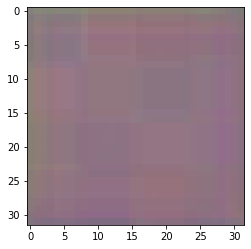

In [153]:
with strategy.scope():
  generator = Generator(64, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, 120], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [154]:
class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(4 * channels, downsample=True, preactivation=False)
    self.res_block_2 = DBlock(4 * channels, downsample=True, preactivation=True)
    self.res_block_3 = DBlock(4 * channels, downsample=False, preactivation=True)
    self.attention = SelfAttention()
    self.res_block_4 = DBlock(4 * channels, downsample=False, preactivation=True)
  
    self.activation = tf.keras.layers.ReLU()
    self.embedding = Embedding(num_classes, 4 * channels, embeddings_initializer=weight_initializer)

    self.linear = SpectralNormalization(
       Dense(1, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully)
    )
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [155]:
with strategy.scope():
  discriminator = Discriminator(64, num_classes=NUM_CLASSES)
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[-0.5194786]], shape=(1, 1), dtype=float32)


In [156]:
per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=per_replica_batch_size,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [157]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_hinge_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor:
  L_D = -tf.reduce_mean(tf.minimum(0., -1.0 + logits_real)) - tf.reduce_mean(tf.minimum(0., -1.0 - logits_fake))

  return L_D    

def generator_hinge_loss(logits_fake: tf.Tensor) -> tf.Tensor:
    L_G = -tf.reduce_mean(logits_fake)
    return L_G  

In [158]:
with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.999,epsilon=1e-6,)
  discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.0, beta_2=0.999, epsilon=1e-6)

In [159]:
fixed_noise = tf.random.truncated_normal((100, LATENT_DIM), stddev=1)

def sample_images(epoch):
  rows = 10
  cols = 10

  noise = fixed_noise

  labels = np.arange(0, 100)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(wspace=0.01, hspace=0)

  fig.set_figheight(100)
  fig.set_figwidth(100)
  fig.set_tight_layout(True)
 
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * 10 + i])
  
      axs[i,j].axis('off')
  plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
  plt.close(fig)

In [160]:
with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_hinge_loss(real_predictions, gen_predictions)
      gen_loss = generator_hinge_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  generator=generator,
  discriminator=discriminator)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)
status = checkpoint.restore(latest_checkpoint, options=local_device_option)

if latest_checkpoint:
  first_epoch = int(latest_checkpoint.split(sep='ckpt-')[-1]) * CHECKPOINT_INTERVAL
else:
  first_epoch = 0

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

def save_checkpoint():
  checkpoint_dir = CHECKPOINT_DIR
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(first_epoch, EPOCHS):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch + 1, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if (epoch + 1) % 5 == 0:
    sample_images(epoch)
  if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()

  print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Epoch: 1/200


  0%|          | 0/406 [00:00<?, ?it/s]

(4, 150) <dtype: 'float32'>


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall_1:2", shape=(4,), dtype=int64), values=Tensor("PartitionedCall_1:1", shape=(4, 120), dtype=float32), dense_shape=Tensor("PartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("concat_1:0", shape=(8,), dtype=int64), values=Tensor("concat:0", shape=(8, 256), dtype=float32), dense_shape=Tensor("PartitionedCall_2:47", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


(4, 150) <dtype: 'float32'>


Current step 406: 100%|██████████| 406/406 [03:35<00:00,  1.88it/s, disc_loss=0.103, gen_loss=1.96]


Time for epoch 1 is 215.73420906066895 sec
Epoch: 2/200


Current step 812: 100%|██████████| 406/406 [00:12<00:00, 32.78it/s, disc_loss=0.0417, gen_loss=1.58]


Time for epoch 2 is 12.390456199645996 sec
Epoch: 3/200


Current step 1218: 100%|██████████| 406/406 [00:12<00:00, 32.94it/s, disc_loss=0.643, gen_loss=0.585]


Time for epoch 3 is 12.329619407653809 sec
Epoch: 4/200


Current step 1624: 100%|██████████| 406/406 [00:12<00:00, 32.67it/s, disc_loss=0.661, gen_loss=1.85]


Time for epoch 4 is 12.433025360107422 sec
Epoch: 5/200


Current step 2030: 100%|██████████| 406/406 [00:12<00:00, 32.76it/s, disc_loss=0.184, gen_loss=2.28]


(100, 150) <dtype: 'float32'>
Time for epoch 5 is 27.58542513847351 sec
Epoch: 6/200


Current step 2436: 100%|██████████| 406/406 [00:12<00:00, 33.01it/s, disc_loss=0.229, gen_loss=1.34]


Time for epoch 6 is 12.306437492370605 sec
Epoch: 7/200


Current step 2842: 100%|██████████| 406/406 [00:12<00:00, 32.89it/s, disc_loss=0.677, gen_loss=1.18]


Time for epoch 7 is 12.351293802261353 sec
Epoch: 8/200


Current step 3248: 100%|██████████| 406/406 [00:12<00:00, 32.91it/s, disc_loss=0.0925, gen_loss=3.07]


Time for epoch 8 is 12.342841386795044 sec
Epoch: 9/200


Current step 3654: 100%|██████████| 406/406 [00:12<00:00, 32.90it/s, disc_loss=0.354, gen_loss=1.32]


Time for epoch 9 is 12.34571123123169 sec
Epoch: 10/200


Current step 4060: 100%|██████████| 406/406 [00:12<00:00, 32.68it/s, disc_loss=0.415, gen_loss=2.96]


Time for epoch 10 is 25.08110809326172 sec
Epoch: 11/200


Current step 4466: 100%|██████████| 406/406 [00:12<00:00, 32.59it/s, disc_loss=0.201, gen_loss=3.59]


Time for epoch 11 is 12.460964679718018 sec
Epoch: 12/200


Current step 4872: 100%|██████████| 406/406 [00:12<00:00, 32.66it/s, disc_loss=0.456, gen_loss=1.19]


Time for epoch 12 is 12.43446660041809 sec
Epoch: 13/200


Current step 5278: 100%|██████████| 406/406 [00:12<00:00, 32.68it/s, disc_loss=0.526, gen_loss=3.13]


Time for epoch 13 is 12.428581237792969 sec
Epoch: 14/200


Current step 5684: 100%|██████████| 406/406 [00:12<00:00, 32.23it/s, disc_loss=0.287, gen_loss=1.76]


Time for epoch 14 is 12.605518102645874 sec
Epoch: 15/200


Current step 6090: 100%|██████████| 406/406 [00:12<00:00, 32.37it/s, disc_loss=0.153, gen_loss=2.19]


Time for epoch 15 is 27.965872287750244 sec
Epoch: 16/200


Current step 6496: 100%|██████████| 406/406 [00:12<00:00, 32.55it/s, disc_loss=0.335, gen_loss=2.28]


Time for epoch 16 is 12.4788498878479 sec
Epoch: 17/200


Current step 6902: 100%|██████████| 406/406 [00:12<00:00, 32.30it/s, disc_loss=0.3, gen_loss=1.61]


Time for epoch 17 is 12.575333833694458 sec
Epoch: 18/200


Current step 7308: 100%|██████████| 406/406 [00:12<00:00, 32.05it/s, disc_loss=0.395, gen_loss=2.65]


Time for epoch 18 is 12.675200700759888 sec
Epoch: 19/200


Current step 7714: 100%|██████████| 406/406 [00:12<00:00, 32.35it/s, disc_loss=0.0754, gen_loss=2.28]


Time for epoch 19 is 12.555582284927368 sec
Epoch: 20/200


Current step 8120: 100%|██████████| 406/406 [00:12<00:00, 32.42it/s, disc_loss=0.149, gen_loss=2.72]


Time for epoch 20 is 25.32905650138855 sec
Epoch: 21/200


Current step 8526: 100%|██████████| 406/406 [00:12<00:00, 32.57it/s, disc_loss=0.204, gen_loss=2.24]


Time for epoch 21 is 12.471270561218262 sec
Epoch: 22/200


Current step 8932: 100%|██████████| 406/406 [00:12<00:00, 32.44it/s, disc_loss=0.118, gen_loss=3.63]


Time for epoch 22 is 12.52028203010559 sec
Epoch: 23/200


Current step 9338: 100%|██████████| 406/406 [00:12<00:00, 32.89it/s, disc_loss=0.0923, gen_loss=2.12]


Time for epoch 23 is 12.351402282714844 sec
Epoch: 24/200


Current step 9744: 100%|██████████| 406/406 [00:12<00:00, 32.70it/s, disc_loss=0.259, gen_loss=1.88]


Time for epoch 24 is 12.420223236083984 sec
Epoch: 25/200


Current step 10150: 100%|██████████| 406/406 [00:12<00:00, 32.60it/s, disc_loss=0.255, gen_loss=3.06]


Time for epoch 25 is 25.06396174430847 sec
Epoch: 26/200


Current step 10556: 100%|██████████| 406/406 [00:12<00:00, 32.52it/s, disc_loss=0.436, gen_loss=3.56]


Time for epoch 26 is 12.490544319152832 sec
Epoch: 27/200


Current step 10962: 100%|██████████| 406/406 [00:12<00:00, 32.72it/s, disc_loss=0.123, gen_loss=2.99]


Time for epoch 27 is 12.413377523422241 sec
Epoch: 28/200


Current step 11368: 100%|██████████| 406/406 [00:12<00:00, 32.74it/s, disc_loss=0.873, gen_loss=0.634]


Time for epoch 28 is 12.406713247299194 sec
Epoch: 29/200


Current step 11774: 100%|██████████| 406/406 [00:12<00:00, 32.49it/s, disc_loss=0.516, gen_loss=3.66]


Time for epoch 29 is 12.501902103424072 sec
Epoch: 30/200


Current step 12180: 100%|██████████| 406/406 [00:12<00:00, 32.41it/s, disc_loss=0.182, gen_loss=1.88]


Time for epoch 30 is 25.191020965576172 sec
Epoch: 31/200


Current step 12586: 100%|██████████| 406/406 [00:12<00:00, 32.35it/s, disc_loss=0.642, gen_loss=0.936]


Time for epoch 31 is 12.556044340133667 sec
Epoch: 32/200


Current step 12992: 100%|██████████| 406/406 [00:12<00:00, 32.32it/s, disc_loss=0.117, gen_loss=1.84]


Time for epoch 32 is 12.56775689125061 sec
Epoch: 33/200


Current step 13398: 100%|██████████| 406/406 [00:12<00:00, 32.38it/s, disc_loss=0.203, gen_loss=2.25]


Time for epoch 33 is 12.544439315795898 sec
Epoch: 34/200


Current step 13804: 100%|██████████| 406/406 [00:12<00:00, 32.66it/s, disc_loss=0.064, gen_loss=2.41]


Time for epoch 34 is 12.43693470954895 sec
Epoch: 35/200


Current step 14210: 100%|██████████| 406/406 [00:12<00:00, 32.35it/s, disc_loss=0.178, gen_loss=2.39]


Time for epoch 35 is 26.734760522842407 sec
Epoch: 36/200


Current step 14616: 100%|██████████| 406/406 [00:12<00:00, 32.61it/s, disc_loss=0.536, gen_loss=1.34]


Time for epoch 36 is 12.456149578094482 sec
Epoch: 37/200


Current step 15022: 100%|██████████| 406/406 [00:12<00:00, 32.69it/s, disc_loss=0.162, gen_loss=2.11]


Time for epoch 37 is 12.423956155776978 sec
Epoch: 38/200


Current step 15428: 100%|██████████| 406/406 [00:12<00:00, 32.77it/s, disc_loss=0.198, gen_loss=3.51]


Time for epoch 38 is 12.39283275604248 sec
Epoch: 39/200


Current step 15834: 100%|██████████| 406/406 [00:12<00:00, 32.54it/s, disc_loss=0.209, gen_loss=3.17]


Time for epoch 39 is 12.482846021652222 sec
Epoch: 40/200


Current step 16240: 100%|██████████| 406/406 [00:12<00:00, 32.32it/s, disc_loss=0.105, gen_loss=2.95]


Time for epoch 40 is 25.392264127731323 sec
Epoch: 41/200


Current step 16646: 100%|██████████| 406/406 [00:12<00:00, 32.53it/s, disc_loss=0.308, gen_loss=3.1]


Time for epoch 41 is 12.487941026687622 sec
Epoch: 42/200


Current step 17052: 100%|██████████| 406/406 [00:12<00:00, 32.75it/s, disc_loss=0.289, gen_loss=3.48]


Time for epoch 42 is 12.402074337005615 sec
Epoch: 43/200


Current step 17458: 100%|██████████| 406/406 [00:12<00:00, 32.72it/s, disc_loss=0.233, gen_loss=3.13]


Time for epoch 43 is 12.413571119308472 sec
Epoch: 44/200


Current step 17864: 100%|██████████| 406/406 [00:12<00:00, 32.34it/s, disc_loss=0.378, gen_loss=3.53]


Time for epoch 44 is 12.557725667953491 sec
Epoch: 45/200


Current step 18270: 100%|██████████| 406/406 [00:12<00:00, 32.60it/s, disc_loss=0.0742, gen_loss=2.1]


Time for epoch 45 is 25.145008325576782 sec
Epoch: 46/200


Current step 18676: 100%|██████████| 406/406 [00:12<00:00, 32.56it/s, disc_loss=0.158, gen_loss=3]


Time for epoch 46 is 12.47445797920227 sec
Epoch: 47/200


Current step 19082: 100%|██████████| 406/406 [00:12<00:00, 32.63it/s, disc_loss=0.187, gen_loss=3.54]


Time for epoch 47 is 12.445905685424805 sec
Epoch: 48/200


Current step 19488: 100%|██████████| 406/406 [00:12<00:00, 32.22it/s, disc_loss=0.183, gen_loss=2.4]


Time for epoch 48 is 12.608185529708862 sec
Epoch: 49/200


Current step 19894: 100%|██████████| 406/406 [00:12<00:00, 32.53it/s, disc_loss=0.0249, gen_loss=2.89]


Time for epoch 49 is 12.486960887908936 sec
Epoch: 50/200


Current step 20300: 100%|██████████| 406/406 [00:12<00:00, 32.73it/s, disc_loss=0.123, gen_loss=3.04]


Time for epoch 50 is 27.377368211746216 sec
Epoch: 51/200


Current step 20706: 100%|██████████| 406/406 [00:12<00:00, 32.16it/s, disc_loss=0.188, gen_loss=2.05]


Time for epoch 51 is 12.626962661743164 sec
Epoch: 52/200


Current step 21112: 100%|██████████| 406/406 [00:12<00:00, 32.53it/s, disc_loss=0.828, gen_loss=4.32]


Time for epoch 52 is 12.487203598022461 sec
Epoch: 53/200


Current step 21518: 100%|██████████| 406/406 [00:12<00:00, 32.53it/s, disc_loss=0.125, gen_loss=2.47]


Time for epoch 53 is 12.485059022903442 sec
Epoch: 54/200


Current step 21924: 100%|██████████| 406/406 [00:12<00:00, 32.50it/s, disc_loss=0.168, gen_loss=3.49]


Time for epoch 54 is 12.498062133789062 sec
Epoch: 55/200


Current step 22330: 100%|██████████| 406/406 [00:12<00:00, 32.78it/s, disc_loss=0.0935, gen_loss=3.18]


Time for epoch 55 is 27.009473085403442 sec
Epoch: 56/200


Current step 22736: 100%|██████████| 406/406 [00:12<00:00, 32.75it/s, disc_loss=0.307, gen_loss=3.67]


Time for epoch 56 is 12.403661727905273 sec
Epoch: 57/200


Current step 23142: 100%|██████████| 406/406 [00:12<00:00, 32.85it/s, disc_loss=0.0646, gen_loss=3.43]


Time for epoch 57 is 12.362149715423584 sec
Epoch: 58/200


Current step 23548: 100%|██████████| 406/406 [00:12<00:00, 32.67it/s, disc_loss=0.263, gen_loss=3.39]


Time for epoch 58 is 12.438515901565552 sec
Epoch: 59/200


Current step 23954: 100%|██████████| 406/406 [00:12<00:00, 32.67it/s, disc_loss=0.443, gen_loss=2.7]


Time for epoch 59 is 12.432683229446411 sec
Epoch: 60/200


Current step 24360: 100%|██████████| 406/406 [00:12<00:00, 32.07it/s, disc_loss=0.0389, gen_loss=2.8]


Time for epoch 60 is 25.323733806610107 sec
Epoch: 61/200


Current step 24766: 100%|██████████| 406/406 [00:12<00:00, 32.65it/s, disc_loss=0.139, gen_loss=2.98]


Time for epoch 61 is 12.440523862838745 sec
Epoch: 62/200


Current step 25172: 100%|██████████| 406/406 [00:12<00:00, 32.24it/s, disc_loss=0.405, gen_loss=4.25]


Time for epoch 62 is 12.599148035049438 sec
Epoch: 63/200


Current step 25578: 100%|██████████| 406/406 [00:12<00:00, 32.64it/s, disc_loss=0.383, gen_loss=3.75]


Time for epoch 63 is 12.443052291870117 sec
Epoch: 64/200


Current step 25984: 100%|██████████| 406/406 [00:12<00:00, 32.47it/s, disc_loss=0.15, gen_loss=3.53]


Time for epoch 64 is 12.508507490158081 sec
Epoch: 65/200


Current step 26390: 100%|██████████| 406/406 [00:12<00:00, 32.86it/s, disc_loss=0.252, gen_loss=2.09]


Time for epoch 65 is 24.88361930847168 sec
Epoch: 66/200


Current step 26796: 100%|██████████| 406/406 [00:12<00:00, 32.51it/s, disc_loss=0.288, gen_loss=3.84]


Time for epoch 66 is 12.491678714752197 sec
Epoch: 67/200


Current step 27202: 100%|██████████| 406/406 [00:12<00:00, 32.63it/s, disc_loss=0.137, gen_loss=3.77]


Time for epoch 67 is 12.444948673248291 sec
Epoch: 68/200


Current step 27608: 100%|██████████| 406/406 [00:12<00:00, 32.59it/s, disc_loss=0.0925, gen_loss=2.59]


Time for epoch 68 is 12.46208119392395 sec
Epoch: 69/200


Current step 28014: 100%|██████████| 406/406 [00:12<00:00, 32.45it/s, disc_loss=0.243, gen_loss=2.08]


Time for epoch 69 is 12.51618504524231 sec
Epoch: 70/200


Current step 28420: 100%|██████████| 406/406 [00:12<00:00, 32.66it/s, disc_loss=0.0354, gen_loss=3.09]


Time for epoch 70 is 24.919217824935913 sec
Epoch: 71/200


Current step 28826: 100%|██████████| 406/406 [00:12<00:00, 33.05it/s, disc_loss=0.131, gen_loss=2.95]


Time for epoch 71 is 12.289007902145386 sec
Epoch: 72/200


Current step 29232: 100%|██████████| 406/406 [00:12<00:00, 32.80it/s, disc_loss=0.0567, gen_loss=2.87]


Time for epoch 72 is 12.384729862213135 sec
Epoch: 73/200


Current step 29638: 100%|██████████| 406/406 [00:12<00:00, 32.42it/s, disc_loss=0.169, gen_loss=1.79]


Time for epoch 73 is 12.528477668762207 sec
Epoch: 74/200


Current step 30044: 100%|██████████| 406/406 [00:12<00:00, 32.71it/s, disc_loss=0.393, gen_loss=1.3]


Time for epoch 74 is 12.41921615600586 sec
Epoch: 75/200


Current step 30450: 100%|██████████| 406/406 [00:12<00:00, 32.79it/s, disc_loss=0.151, gen_loss=3.7]


Time for epoch 75 is 24.89491891860962 sec
Epoch: 76/200


Current step 30856: 100%|██████████| 406/406 [00:12<00:00, 33.02it/s, disc_loss=0.274, gen_loss=2.05]


Time for epoch 76 is 12.299102783203125 sec
Epoch: 77/200


Current step 31262: 100%|██████████| 406/406 [00:12<00:00, 32.80it/s, disc_loss=0.233, gen_loss=3.66]


Time for epoch 77 is 12.38124966621399 sec
Epoch: 78/200


Current step 31668: 100%|██████████| 406/406 [00:12<00:00, 32.30it/s, disc_loss=0.169, gen_loss=2.31]


Time for epoch 78 is 12.573124647140503 sec
Epoch: 79/200


Current step 32074: 100%|██████████| 406/406 [00:12<00:00, 32.35it/s, disc_loss=0.0533, gen_loss=2.68]


Time for epoch 79 is 12.552988052368164 sec
Epoch: 80/200


Current step 32480: 100%|██████████| 406/406 [00:12<00:00, 31.84it/s, disc_loss=0.229, gen_loss=1.91]


Time for epoch 80 is 25.509514093399048 sec
Epoch: 81/200


Current step 32886: 100%|██████████| 406/406 [00:12<00:00, 32.29it/s, disc_loss=0.833, gen_loss=0.756]


Time for epoch 81 is 12.578863620758057 sec
Epoch: 82/200


Current step 33292: 100%|██████████| 406/406 [00:12<00:00, 32.74it/s, disc_loss=0.0755, gen_loss=3.17]


Time for epoch 82 is 12.406822919845581 sec
Epoch: 83/200


Current step 33698: 100%|██████████| 406/406 [00:12<00:00, 32.61it/s, disc_loss=0.379, gen_loss=1.23]


Time for epoch 83 is 12.453966617584229 sec
Epoch: 84/200


Current step 34104: 100%|██████████| 406/406 [00:12<00:00, 32.85it/s, disc_loss=0.0395, gen_loss=3.23]


Time for epoch 84 is 12.365189790725708 sec
Epoch: 85/200


Current step 34510: 100%|██████████| 406/406 [00:12<00:00, 32.91it/s, disc_loss=0.199, gen_loss=2.14]


Time for epoch 85 is 27.5884370803833 sec
Epoch: 86/200


Current step 34916: 100%|██████████| 406/406 [00:12<00:00, 32.60it/s, disc_loss=0.13, gen_loss=3.23]


Time for epoch 86 is 12.46045708656311 sec
Epoch: 87/200


Current step 35322: 100%|██████████| 406/406 [00:12<00:00, 33.04it/s, disc_loss=0.177, gen_loss=2.36]


Time for epoch 87 is 12.294127225875854 sec
Epoch: 88/200


Current step 35728: 100%|██████████| 406/406 [00:12<00:00, 32.98it/s, disc_loss=0.217, gen_loss=1.84]


Time for epoch 88 is 12.315672159194946 sec
Epoch: 89/200


Current step 36134: 100%|██████████| 406/406 [00:12<00:00, 32.87it/s, disc_loss=0.067, gen_loss=2.48]


Time for epoch 89 is 12.357136964797974 sec
Epoch: 90/200


Current step 36540: 100%|██████████| 406/406 [00:12<00:00, 32.69it/s, disc_loss=0.175, gen_loss=2.59]


Time for epoch 90 is 25.009658575057983 sec
Epoch: 91/200


Current step 36946: 100%|██████████| 406/406 [00:12<00:00, 32.64it/s, disc_loss=0.161, gen_loss=2.32]


Time for epoch 91 is 12.443530797958374 sec
Epoch: 92/200


Current step 37352: 100%|██████████| 406/406 [00:12<00:00, 32.77it/s, disc_loss=0.0806, gen_loss=2.25]


Time for epoch 92 is 12.39181137084961 sec
Epoch: 93/200


Current step 37758: 100%|██████████| 406/406 [00:12<00:00, 32.42it/s, disc_loss=0.126, gen_loss=2.84]


Time for epoch 93 is 12.529048919677734 sec
Epoch: 94/200


Current step 38164: 100%|██████████| 406/406 [00:12<00:00, 32.42it/s, disc_loss=0.123, gen_loss=3.32]


Time for epoch 94 is 12.529046535491943 sec
Epoch: 95/200


Current step 38570: 100%|██████████| 406/406 [00:12<00:00, 32.72it/s, disc_loss=0.0422, gen_loss=2.93]


Time for epoch 95 is 25.200589895248413 sec
Epoch: 96/200


Current step 38976: 100%|██████████| 406/406 [00:12<00:00, 32.59it/s, disc_loss=0.0804, gen_loss=2.66]


Time for epoch 96 is 12.461555004119873 sec
Epoch: 97/200


Current step 39382: 100%|██████████| 406/406 [00:12<00:00, 32.76it/s, disc_loss=0.249, gen_loss=2.36]


Time for epoch 97 is 12.397551536560059 sec
Epoch: 98/200


Current step 39788: 100%|██████████| 406/406 [00:12<00:00, 32.78it/s, disc_loss=0.0532, gen_loss=2.83]


Time for epoch 98 is 12.390194654464722 sec
Epoch: 99/200


Current step 40194: 100%|██████████| 406/406 [00:12<00:00, 32.91it/s, disc_loss=0.0906, gen_loss=2.32]


Time for epoch 99 is 12.34075140953064 sec
Epoch: 100/200


Current step 40600: 100%|██████████| 406/406 [00:12<00:00, 32.61it/s, disc_loss=0.0857, gen_loss=2.5]


Time for epoch 100 is 26.967323303222656 sec
Epoch: 101/200


Current step 41006: 100%|██████████| 406/406 [00:12<00:00, 32.30it/s, disc_loss=0.0766, gen_loss=2.43]


Time for epoch 101 is 12.573922395706177 sec
Epoch: 102/200


Current step 41412: 100%|██████████| 406/406 [00:12<00:00, 33.03it/s, disc_loss=0.0895, gen_loss=2.85]


Time for epoch 102 is 12.29773211479187 sec
Epoch: 103/200


Current step 41818: 100%|██████████| 406/406 [00:12<00:00, 32.67it/s, disc_loss=0.166, gen_loss=3.04]


Time for epoch 103 is 12.433046817779541 sec
Epoch: 104/200


Current step 42224: 100%|██████████| 406/406 [00:12<00:00, 32.84it/s, disc_loss=0.27, gen_loss=2.52]


Time for epoch 104 is 12.366892576217651 sec
Epoch: 105/200


Current step 42630: 100%|██████████| 406/406 [00:12<00:00, 32.91it/s, disc_loss=0.0783, gen_loss=2.44]


Time for epoch 105 is 24.68665051460266 sec
Epoch: 106/200


Current step 43036: 100%|██████████| 406/406 [00:12<00:00, 32.81it/s, disc_loss=0.193, gen_loss=2.04]


Time for epoch 106 is 12.38198184967041 sec
Epoch: 107/200


Current step 43442: 100%|██████████| 406/406 [00:12<00:00, 32.94it/s, disc_loss=0.0848, gen_loss=3.15]


Time for epoch 107 is 12.329090595245361 sec
Epoch: 108/200


Current step 43848: 100%|██████████| 406/406 [00:12<00:00, 33.00it/s, disc_loss=0.131, gen_loss=3.09]


Time for epoch 108 is 12.30971884727478 sec
Epoch: 109/200


Current step 44254: 100%|██████████| 406/406 [00:12<00:00, 33.02it/s, disc_loss=0.127, gen_loss=2.93]


Time for epoch 109 is 12.299233436584473 sec
Epoch: 110/200


Current step 44660: 100%|██████████| 406/406 [00:12<00:00, 33.04it/s, disc_loss=0.0757, gen_loss=2.34]


Time for epoch 110 is 24.58611822128296 sec
Epoch: 111/200


Current step 45066: 100%|██████████| 406/406 [00:12<00:00, 32.96it/s, disc_loss=0.178, gen_loss=3.2]


Time for epoch 111 is 12.323207378387451 sec
Epoch: 112/200


Current step 45472: 100%|██████████| 406/406 [00:12<00:00, 32.94it/s, disc_loss=0.547, gen_loss=0.911]


Time for epoch 112 is 12.328766584396362 sec
Epoch: 113/200


Current step 45878: 100%|██████████| 406/406 [00:12<00:00, 33.07it/s, disc_loss=0.185, gen_loss=2.04]


Time for epoch 113 is 12.2821626663208 sec
Epoch: 114/200


Current step 46284: 100%|██████████| 406/406 [00:12<00:00, 33.08it/s, disc_loss=0.0707, gen_loss=2.83]


Time for epoch 114 is 12.278422594070435 sec
Epoch: 115/200


Current step 46690: 100%|██████████| 406/406 [00:12<00:00, 32.92it/s, disc_loss=0.211, gen_loss=2.07]


Time for epoch 115 is 24.563806533813477 sec
Epoch: 116/200


Current step 47096: 100%|██████████| 406/406 [00:12<00:00, 33.06it/s, disc_loss=0.446, gen_loss=1.75]


Time for epoch 116 is 12.285191774368286 sec
Epoch: 117/200


Current step 47502: 100%|██████████| 406/406 [00:12<00:00, 33.01it/s, disc_loss=0.289, gen_loss=3.05]


Time for epoch 117 is 12.30537486076355 sec
Epoch: 118/200


Current step 47908: 100%|██████████| 406/406 [00:12<00:00, 33.16it/s, disc_loss=0.104, gen_loss=2.28]


Time for epoch 118 is 12.249349117279053 sec
Epoch: 119/200


Current step 48314: 100%|██████████| 406/406 [00:12<00:00, 33.06it/s, disc_loss=0.182, gen_loss=2.4]


Time for epoch 119 is 12.284372568130493 sec
Epoch: 120/200


Current step 48720: 100%|██████████| 406/406 [00:12<00:00, 32.47it/s, disc_loss=0.0161, gen_loss=2.66]


Time for epoch 120 is 24.875104427337646 sec
Epoch: 121/200


Current step 49126: 100%|██████████| 406/406 [00:12<00:00, 33.06it/s, disc_loss=0.295, gen_loss=4.17]


Time for epoch 121 is 12.286281824111938 sec
Epoch: 122/200


Current step 49532: 100%|██████████| 406/406 [00:12<00:00, 32.89it/s, disc_loss=0.438, gen_loss=1.57]


Time for epoch 122 is 12.349319458007812 sec
Epoch: 123/200


Current step 49938: 100%|██████████| 406/406 [00:12<00:00, 32.80it/s, disc_loss=0.195, gen_loss=3.08]


Time for epoch 123 is 12.381791353225708 sec
Epoch: 124/200


Current step 50344: 100%|██████████| 406/406 [00:12<00:00, 33.10it/s, disc_loss=0.316, gen_loss=2.23]


Time for epoch 124 is 12.27008867263794 sec
Epoch: 125/200


Current step 50750: 100%|██████████| 406/406 [00:12<00:00, 33.01it/s, disc_loss=0.256, gen_loss=2.43]


Time for epoch 125 is 27.7321720123291 sec
Epoch: 126/200


Current step 51156: 100%|██████████| 406/406 [00:12<00:00, 32.98it/s, disc_loss=0.202, gen_loss=2.25]


Time for epoch 126 is 12.314094543457031 sec
Epoch: 127/200


Current step 51562: 100%|██████████| 406/406 [00:12<00:00, 33.15it/s, disc_loss=0.154, gen_loss=3.03]


Time for epoch 127 is 12.252578258514404 sec
Epoch: 128/200


Current step 51968: 100%|██████████| 406/406 [00:12<00:00, 32.46it/s, disc_loss=0.417, gen_loss=3.53]


Time for epoch 128 is 12.515175580978394 sec
Epoch: 129/200


Current step 52374: 100%|██████████| 406/406 [00:12<00:00, 33.09it/s, disc_loss=0.0387, gen_loss=2.93]


Time for epoch 129 is 12.273133516311646 sec
Epoch: 130/200


Current step 52780: 100%|██████████| 406/406 [00:12<00:00, 33.09it/s, disc_loss=0.299, gen_loss=3.16]


Time for epoch 130 is 24.382386922836304 sec
Epoch: 131/200


Current step 53186: 100%|██████████| 406/406 [00:12<00:00, 32.92it/s, disc_loss=0.0867, gen_loss=2.6]


Time for epoch 131 is 12.336153268814087 sec
Epoch: 132/200


Current step 53592: 100%|██████████| 406/406 [00:12<00:00, 32.92it/s, disc_loss=0.168, gen_loss=2.93]


Time for epoch 132 is 12.336734056472778 sec
Epoch: 133/200


Current step 53998: 100%|██████████| 406/406 [00:12<00:00, 33.12it/s, disc_loss=0.0895, gen_loss=2.82]


Time for epoch 133 is 12.263509273529053 sec
Epoch: 134/200


Current step 54404: 100%|██████████| 406/406 [00:12<00:00, 32.85it/s, disc_loss=0.116, gen_loss=2.19]


Time for epoch 134 is 12.361886978149414 sec
Epoch: 135/200


Current step 54810: 100%|██████████| 406/406 [00:12<00:00, 33.27it/s, disc_loss=0.22, gen_loss=2.5]


Time for epoch 135 is 24.44435405731201 sec
Epoch: 136/200


Current step 55216: 100%|██████████| 406/406 [00:12<00:00, 32.69it/s, disc_loss=0.145, gen_loss=2.3]


Time for epoch 136 is 12.425877809524536 sec
Epoch: 137/200


Current step 55622: 100%|██████████| 406/406 [00:12<00:00, 32.47it/s, disc_loss=0.42, gen_loss=1.51]


Time for epoch 137 is 12.507252931594849 sec
Epoch: 138/200


Current step 56028: 100%|██████████| 406/406 [00:12<00:00, 32.70it/s, disc_loss=0.114, gen_loss=3.07]


Time for epoch 138 is 12.421850681304932 sec
Epoch: 139/200


Current step 56434: 100%|██████████| 406/406 [00:12<00:00, 32.95it/s, disc_loss=0.189, gen_loss=1.82]


Time for epoch 139 is 12.32578420639038 sec
Epoch: 140/200


Current step 56840: 100%|██████████| 406/406 [00:12<00:00, 32.48it/s, disc_loss=0.414, gen_loss=3.27]


Time for epoch 140 is 24.93795347213745 sec
Epoch: 141/200


Current step 57246: 100%|██████████| 406/406 [00:12<00:00, 33.06it/s, disc_loss=0.357, gen_loss=1.7]


Time for epoch 141 is 12.288031578063965 sec
Epoch: 142/200


Current step 57652: 100%|██████████| 406/406 [00:12<00:00, 32.47it/s, disc_loss=0.233, gen_loss=2.43]


Time for epoch 142 is 12.509052276611328 sec
Epoch: 143/200


Current step 58058: 100%|██████████| 406/406 [00:12<00:00, 33.18it/s, disc_loss=0.466, gen_loss=3.32]


Time for epoch 143 is 12.24253511428833 sec
Epoch: 144/200


Current step 58464: 100%|██████████| 406/406 [00:12<00:00, 33.42it/s, disc_loss=0.14, gen_loss=2.57]


Time for epoch 144 is 12.152795791625977 sec
Epoch: 145/200


Current step 58870: 100%|██████████| 406/406 [00:12<00:00, 32.91it/s, disc_loss=0.445, gen_loss=3.26]


Time for epoch 145 is 24.57815980911255 sec
Epoch: 146/200


Current step 59276: 100%|██████████| 406/406 [00:12<00:00, 32.96it/s, disc_loss=0.258, gen_loss=2.13]


Time for epoch 146 is 12.322377443313599 sec
Epoch: 147/200


Current step 59682: 100%|██████████| 406/406 [00:12<00:00, 33.14it/s, disc_loss=0.156, gen_loss=2.16]


Time for epoch 147 is 12.254832744598389 sec
Epoch: 148/200


Current step 60088: 100%|██████████| 406/406 [00:12<00:00, 33.02it/s, disc_loss=0.4, gen_loss=3.09]


Time for epoch 148 is 12.300954818725586 sec
Epoch: 149/200


Current step 60494: 100%|██████████| 406/406 [00:12<00:00, 32.96it/s, disc_loss=0.385, gen_loss=3.63]


Time for epoch 149 is 12.323844194412231 sec
Epoch: 150/200


Current step 60900: 100%|██████████| 406/406 [00:12<00:00, 33.08it/s, disc_loss=0.197, gen_loss=2.13]


Time for epoch 150 is 26.497353553771973 sec
Epoch: 151/200


Current step 61306: 100%|██████████| 406/406 [00:12<00:00, 32.56it/s, disc_loss=0.131, gen_loss=2.93]


Time for epoch 151 is 12.474931240081787 sec
Epoch: 152/200


Current step 61712: 100%|██████████| 406/406 [00:12<00:00, 33.06it/s, disc_loss=0.302, gen_loss=1.55]


Time for epoch 152 is 12.285378694534302 sec
Epoch: 153/200


Current step 62118: 100%|██████████| 406/406 [00:12<00:00, 33.26it/s, disc_loss=0.285, gen_loss=1.82]


Time for epoch 153 is 12.211250305175781 sec
Epoch: 154/200


Current step 62524: 100%|██████████| 406/406 [00:12<00:00, 33.08it/s, disc_loss=0.21, gen_loss=2.36]


Time for epoch 154 is 12.278136730194092 sec
Epoch: 155/200


Current step 62930: 100%|██████████| 406/406 [00:12<00:00, 33.28it/s, disc_loss=0.712, gen_loss=0.815]


Time for epoch 155 is 24.346700191497803 sec
Epoch: 156/200


Current step 63336: 100%|██████████| 406/406 [00:12<00:00, 33.26it/s, disc_loss=0.226, gen_loss=2.17]


Time for epoch 156 is 12.212987661361694 sec
Epoch: 157/200


Current step 63742: 100%|██████████| 406/406 [00:12<00:00, 33.10it/s, disc_loss=0.208, gen_loss=3.08]


Time for epoch 157 is 12.271507024765015 sec
Epoch: 158/200


Current step 64148: 100%|██████████| 406/406 [00:12<00:00, 33.32it/s, disc_loss=0.204, gen_loss=2.17]


Time for epoch 158 is 12.190499067306519 sec
Epoch: 159/200


Current step 64554: 100%|██████████| 406/406 [00:12<00:00, 33.17it/s, disc_loss=0.305, gen_loss=2.69]


Time for epoch 159 is 12.2435941696167 sec
Epoch: 160/200


Current step 64960: 100%|██████████| 406/406 [00:12<00:00, 32.79it/s, disc_loss=0.425, gen_loss=1.38]


Time for epoch 160 is 24.79914402961731 sec
Epoch: 161/200


Current step 65366: 100%|██████████| 406/406 [00:12<00:00, 32.99it/s, disc_loss=0.0961, gen_loss=3.11]


Time for epoch 161 is 12.313145875930786 sec
Epoch: 162/200


Current step 65772: 100%|██████████| 406/406 [00:12<00:00, 33.04it/s, disc_loss=0.213, gen_loss=2.4]


Time for epoch 162 is 12.291733741760254 sec
Epoch: 163/200


Current step 66178: 100%|██████████| 406/406 [00:12<00:00, 32.86it/s, disc_loss=0.191, gen_loss=2.77]


Time for epoch 163 is 12.360942125320435 sec
Epoch: 164/200


Current step 66584: 100%|██████████| 406/406 [00:12<00:00, 33.10it/s, disc_loss=0.21, gen_loss=2.66]


Time for epoch 164 is 12.271642923355103 sec
Epoch: 165/200


Current step 66990: 100%|██████████| 406/406 [00:12<00:00, 33.00it/s, disc_loss=0.576, gen_loss=3.78]


Time for epoch 165 is 24.733026266098022 sec
Epoch: 166/200


Current step 67396: 100%|██████████| 406/406 [00:12<00:00, 32.71it/s, disc_loss=0.0975, gen_loss=2.68]


Time for epoch 166 is 12.418024063110352 sec
Epoch: 167/200


Current step 67802: 100%|██████████| 406/406 [00:12<00:00, 33.07it/s, disc_loss=0.331, gen_loss=1.46]


Time for epoch 167 is 12.282601356506348 sec
Epoch: 168/200


Current step 68208: 100%|██████████| 406/406 [00:12<00:00, 33.44it/s, disc_loss=0.119, gen_loss=2.23]


Time for epoch 168 is 12.146036148071289 sec
Epoch: 169/200


Current step 68614: 100%|██████████| 406/406 [00:12<00:00, 33.00it/s, disc_loss=0.215, gen_loss=1.81]


Time for epoch 169 is 12.306116580963135 sec
Epoch: 170/200


Current step 69020: 100%|██████████| 406/406 [00:12<00:00, 33.47it/s, disc_loss=0.0952, gen_loss=3.19]


Time for epoch 170 is 28.14308738708496 sec
Epoch: 171/200


Current step 69426: 100%|██████████| 406/406 [00:12<00:00, 33.62it/s, disc_loss=0.17, gen_loss=2.55]


Time for epoch 171 is 12.080689191818237 sec
Epoch: 172/200


Current step 69832: 100%|██████████| 406/406 [00:12<00:00, 33.78it/s, disc_loss=0.176, gen_loss=2.92]


Time for epoch 172 is 12.023252248764038 sec
Epoch: 173/200


Current step 70238: 100%|██████████| 406/406 [00:12<00:00, 33.60it/s, disc_loss=0.304, gen_loss=2.17]


Time for epoch 173 is 12.088168621063232 sec
Epoch: 174/200


Current step 70644: 100%|██████████| 406/406 [00:12<00:00, 33.24it/s, disc_loss=0.242, gen_loss=2.47]


Time for epoch 174 is 12.218252897262573 sec
Epoch: 175/200


Current step 71050: 100%|██████████| 406/406 [00:12<00:00, 33.65it/s, disc_loss=0.335, gen_loss=2.19]


Time for epoch 175 is 24.14968252182007 sec
Epoch: 176/200


Current step 71456: 100%|██████████| 406/406 [00:12<00:00, 33.47it/s, disc_loss=0.0948, gen_loss=2.23]


Time for epoch 176 is 12.137601613998413 sec
Epoch: 177/200


Current step 71862: 100%|██████████| 406/406 [00:12<00:00, 33.68it/s, disc_loss=0.104, gen_loss=2.39]


Time for epoch 177 is 12.058472156524658 sec
Epoch: 178/200


Current step 72268: 100%|██████████| 406/406 [00:12<00:00, 33.61it/s, disc_loss=0.0431, gen_loss=2.76]


Time for epoch 178 is 12.083433866500854 sec
Epoch: 179/200


Current step 72674: 100%|██████████| 406/406 [00:12<00:00, 33.59it/s, disc_loss=0.379, gen_loss=1.47]


Time for epoch 179 is 12.089912176132202 sec
Epoch: 180/200


Current step 73080: 100%|██████████| 406/406 [00:12<00:00, 33.54it/s, disc_loss=0.202, gen_loss=2.55]


Time for epoch 180 is 24.633684873580933 sec
Epoch: 181/200


Current step 73486: 100%|██████████| 406/406 [00:12<00:00, 33.80it/s, disc_loss=0.131, gen_loss=2.72]


Time for epoch 181 is 12.015926599502563 sec
Epoch: 182/200


Current step 73892: 100%|██████████| 406/406 [00:12<00:00, 33.73it/s, disc_loss=0.19, gen_loss=2.93]


Time for epoch 182 is 12.040990829467773 sec
Epoch: 183/200


Current step 74298: 100%|██████████| 406/406 [00:12<00:00, 33.32it/s, disc_loss=0.141, gen_loss=2.26]


Time for epoch 183 is 12.192155122756958 sec
Epoch: 184/200


Current step 74704: 100%|██████████| 406/406 [00:12<00:00, 33.17it/s, disc_loss=0.227, gen_loss=2.83]


Time for epoch 184 is 12.24233341217041 sec
Epoch: 185/200


Current step 75110: 100%|██████████| 406/406 [00:12<00:00, 33.38it/s, disc_loss=0.156, gen_loss=2.94]


Time for epoch 185 is 24.36439323425293 sec
Epoch: 186/200


Current step 75516: 100%|██████████| 406/406 [00:12<00:00, 32.94it/s, disc_loss=0.344, gen_loss=3.54]


Time for epoch 186 is 12.330304384231567 sec
Epoch: 187/200


Current step 75922: 100%|██████████| 406/406 [00:12<00:00, 33.18it/s, disc_loss=0.111, gen_loss=2.47]


Time for epoch 187 is 12.24047064781189 sec
Epoch: 188/200


Current step 76328: 100%|██████████| 406/406 [00:12<00:00, 33.56it/s, disc_loss=0.263, gen_loss=2.74]


Time for epoch 188 is 12.10029911994934 sec
Epoch: 189/200


Current step 76734: 100%|██████████| 406/406 [00:11<00:00, 33.91it/s, disc_loss=0.145, gen_loss=2.75]


Time for epoch 189 is 11.979701280593872 sec
Epoch: 190/200


Current step 77140: 100%|██████████| 406/406 [00:12<00:00, 33.44it/s, disc_loss=0.463, gen_loss=1.36]


Time for epoch 190 is 24.151267766952515 sec
Epoch: 191/200


Current step 77546: 100%|██████████| 406/406 [00:12<00:00, 33.45it/s, disc_loss=0.428, gen_loss=3.58]


Time for epoch 191 is 12.14255428314209 sec
Epoch: 192/200


Current step 77952: 100%|██████████| 406/406 [00:12<00:00, 33.57it/s, disc_loss=0.333, gen_loss=2.6]


Time for epoch 192 is 12.099034786224365 sec
Epoch: 193/200


Current step 78358: 100%|██████████| 406/406 [00:12<00:00, 33.64it/s, disc_loss=0.321, gen_loss=3.32]


Time for epoch 193 is 12.072914361953735 sec
Epoch: 194/200


Current step 78764: 100%|██████████| 406/406 [00:12<00:00, 33.70it/s, disc_loss=0.133, gen_loss=2.7]


Time for epoch 194 is 12.050076007843018 sec
Epoch: 195/200


Current step 79170: 100%|██████████| 406/406 [00:12<00:00, 33.56it/s, disc_loss=0.238, gen_loss=3.24]


Time for epoch 195 is 24.079524040222168 sec
Epoch: 196/200


Current step 79576: 100%|██████████| 406/406 [00:12<00:00, 33.59it/s, disc_loss=0.183, gen_loss=3.03]


Time for epoch 196 is 12.093546867370605 sec
Epoch: 197/200


Current step 79982: 100%|██████████| 406/406 [00:12<00:00, 33.71it/s, disc_loss=0.385, gen_loss=2.48]


Time for epoch 197 is 12.049917697906494 sec
Epoch: 198/200


Current step 80388: 100%|██████████| 406/406 [00:12<00:00, 33.52it/s, disc_loss=0.194, gen_loss=2.83]


Time for epoch 198 is 12.115940570831299 sec
Epoch: 199/200


Current step 80794: 100%|██████████| 406/406 [00:12<00:00, 33.34it/s, disc_loss=0.182, gen_loss=2.79]


Time for epoch 199 is 12.18082571029663 sec
Epoch: 200/200


Current step 81200: 100%|██████████| 406/406 [00:12<00:00, 33.43it/s, disc_loss=0.0406, gen_loss=2.62]


Time for epoch 200 is 26.298611402511597 sec
